## Determinantes del rendimiento académico: Un análisis predictivo basado en factores socio-demográficos y evaluaciones periódicas

El presente reporte técnico aborda el análisis de los factores que influyen en el logro educativo de estudiantes de nivel secundaria en dos instituciones de Portugal (Gabriel Pereira y Mousinho da Silveira). Los datos analizados, basados en el estudio de **Cortez y Silva (2008)**, integran no solo calificaciones académicas, sino también una rica variedad de atributos demográficos, sociales y relacionados con el entorno escolar obtenidos mediante informes administrativos y cuestionarios directos.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargando los datos
df = pd.read_csv('A1.3 Calificaciones.csv')

# Visualización de datos
print("Estructura del Dataset:")
display(df.info(10))
display(df.head(10))

Estructura del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Escuela         395 non-null    object
 1   Sexo            395 non-null    object
 2   Edad            395 non-null    int64 
 3   HorasDeEstudio  395 non-null    int64 
 4   Reprobadas      395 non-null    int64 
 5   Internet        395 non-null    object
 6   Faltas          395 non-null    int64 
 7   G1              395 non-null    int64 
 8   G2              395 non-null    int64 
 9   G3              395 non-null    int64 
dtypes: int64(7), object(3)
memory usage: 31.0+ KB


None

,Escuela,Sexo,Edad,HorasDeEstudio,Reprobadas,Internet,Faltas,G1,G2,G3
0,GP,F,18,2,0,no,6,5,6,6
1,GP,F,17,2,0,yes,4,5,5,6
2,GP,F,15,2,3,yes,10,7,8,10
3,GP,F,15,3,0,yes,2,15,14,15
4,GP,F,16,2,0,no,4,6,10,10
5,GP,M,16,2,0,yes,10,15,15,15
6,GP,M,16,2,0,yes,0,12,12,11
7,GP,F,17,2,0,no,6,6,5,6
8,GP,M,15,2,0,yes,0,16,18,19
9,GP,M,15,2,0,yes,0,14,15,15


## 1. Exploración y comprensión del conjunto de datos

El análisis comienza con la categorización de los atributos para identificar su impacto potencial en el modelo de regresión. El conjunto de datos, basado en el estudio de **Cortez y Silva (2008)**, presenta una mezcla de factores demográficos y académicos.

### Clasificación y naturaleza de las variables

| Variable | Naturaleza | Escala | Descripción |
| :--- | :--- | :--- | :--- |
| **Escuela, Sexo, Internet** | Cualitativa | Nominal | Factores categóricos que requieren codificación numérica. |
| **HorasDeEstudio** | Cuantitativa | Ordinal | Escala jerárquica de tiempo dedicado (1 a 4). |
| **Edad, Reprobadas, Faltas** | Cuantitativa | Discreta | Conteos numéricos con presencia de valores atípicos. |
| **G1, G2, G3 (Target)** | Cuantitativa | Continua | Calificaciones en escala 0-20. |

## 2. Identificación de problemas en los datos (evidencias)

Antes de proceder a la limpieza, se realizaron pruebas diagnósticas para confirmar la existencia de los retos metodológicos planteados.



### A. Incompatibilidad de formato (variables categóricas)
Las variables `Escuela`, `Sexo` e `Internet` se encuentran en formato de texto (object). El modelo de regresión lineal requiere entradas numéricas para calcular los pesos de cada característica.

In [2]:
print("Tipos de datos de las variables categóricas:")
display(df[['Escuela', 'Sexo', 'Internet']].dtypes)

print("\nValores únicos presentes:")
for col in ['Escuela', 'Sexo', 'Internet']:
    print(f"{col}: {df[col].unique()}")

Tipos de datos de las variables categóricas:


Escuela     object
Sexo        object
Internet    object
dtype: object


Valores únicos presentes:
Escuela: ['GP' 'MS']
Sexo: ['F' 'M']
Internet: ['no' 'yes']


### B. Presencia de valores atípicos
La variable `Faltas` muestra una dispersión que podría sesgar el modelo. Se sospecha la presencia de valores que se alejan significativamente del promedio.

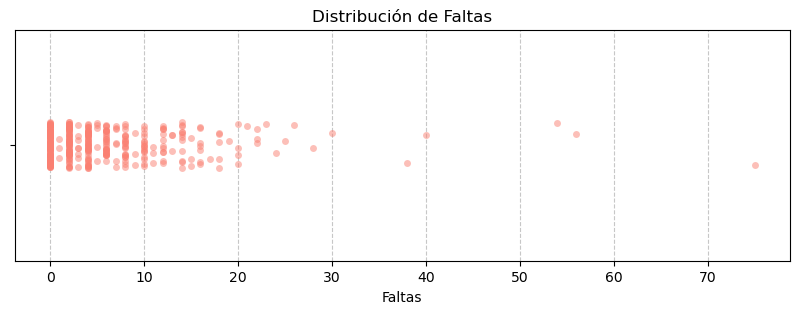

In [3]:
plt.figure(figsize=(10, 3))
sns.stripplot(x=df['Faltas'], color='salmon', alpha=0.5, jitter=True)
plt.title('Distribución de Faltas')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### C. Anomalías en la variable objetivo ($G3$)
Se observa un comportamiento inusual en la calificación final: un grupo de estudiantes tiene una nota de 0, a pesar de haber tenido un desempeño aceptable en los periodos previos ($G1$ y $G2$).

In [4]:
conteo_ceros = (df['G3'] == 0).sum()
print(f"Total de estudiantes con calificación 0 en G3: {conteo_ceros}")

# Casos donde el alumno aprobaba (>=10) pero terminó con 0
anomalos = df[(df['G1'] >= 10) & (df['G2'] >= 10) & (df['G3'] == 0)]
print(f"Casos con notas previas aprobatorias y final de cero: {len(anomalos)}")
display(anomalos[['G1', 'G2', 'G3']].head())

Total de estudiantes con calificación 0 en G3: 38
Casos con notas previas aprobatorias y final de cero: 1


,G1,G2,G3
341,10,10,0


### D. Redundancia de información (Colinealidad)
Se analiza la correlación entre las notas de los tres periodos. Una correlación demasiado alta entre variables explicativas (como $G1$ y $G2$) puede invalidar la interpretación de los coeficientes del modelo.

Matriz de correlación entre calificaciones:


,G1,G2,G3
G1,1.000000,0.852118,0.801468
G2,0.852118,1.000000,0.904868
G3,0.801468,0.904868,1.000000


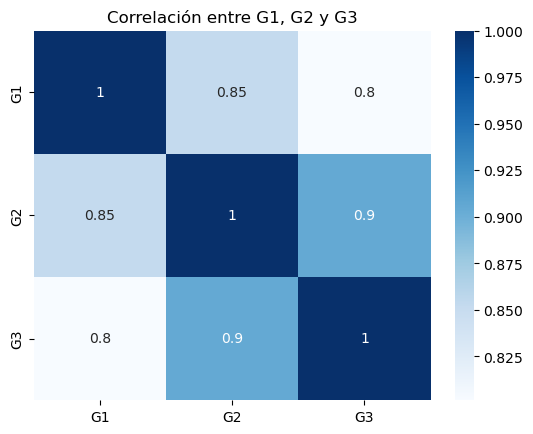

In [5]:
corr_notas = df[['G1', 'G2', 'G3']].corr()
print("Matriz de correlación entre calificaciones:")
display(corr_notas)

sns.heatmap(corr_notas, annot=True, cmap='Blues')
plt.title('Correlación entre G1, G2 y G3')
plt.show()

## 3. Preparación y limpieza de los datos

Basado en las evidencias anteriores, se procedió a:
1. **Codificar** las variables nominales a binarias (0 y 1).
2. **Limitar** la variable `Faltas` para reducir el ruido de los outliers.
3. **Seleccionar variables** eliminando la redundancia detectada entre $G1$ y $G2$.

In [6]:
import numpy as np
import pandas as pd

if 'df' not in locals():
    try:
        df = pd.read_csv('A1.3 Calificaciones.csv')
        print("Archivo recargado exitosamente.")
    except FileNotFoundError:
        print("Error: No se encontró el archivo CSV. Asegúrate de que esté en la misma carpeta.")

df_clean = df.copy()


df_clean['Escuela'] = df_clean['Escuela'].map({'GP': 0, 'MS': 1})
df_clean['Sexo'] = df_clean['Sexo'].map({'F': 0, 'M': 1})
df_clean['Internet'] = df_clean['Internet'].map({'no': 0, 'yes': 1})


limite = df_clean['Faltas'].quantile(0.95)
df_clean['Faltas'] = np.where(df_clean['Faltas'] > limite, limite, df_clean['Faltas'])

print(f"Limpieza ejecutada exitosamente. Límite de faltas aplicado: {limite}")
display(df_clean.head(10))

Limpieza ejecutada exitosamente. Límite de faltas aplicado: 18.299999999999955


,Escuela,Sexo,Edad,HorasDeEstudio,Reprobadas,Internet,Faltas,G1,G2,G3
0,0,0,18,2,0,0,6.0,5,6,6
1,0,0,17,2,0,1,4.0,5,5,6
2,0,0,15,2,3,1,10.0,7,8,10
3,0,0,15,3,0,1,2.0,15,14,15
4,0,0,16,2,0,0,4.0,6,10,10
5,0,1,16,2,0,1,10.0,15,15,15
6,0,1,16,2,0,1,0.0,12,12,11
7,0,0,17,2,0,0,6.0,6,5,6
8,0,1,15,2,0,1,0.0,16,18,19
9,0,1,15,2,0,1,0.0,14,15,15


## 4. Análisis de relaciones entre variables

En esta sección se analiza la interacción entre los predictores para identificar problemas de **colinealidad** o redundancia. El objetivo es asegurar que cada variable aporte información única al modelo.

### Matriz de correlación
Como se anticipó en los retos iniciales, existe una relación crítica entre las calificaciones de los periodos. La visualización a continuación permite confirmar si es conveniente conservar todas las variables originales.

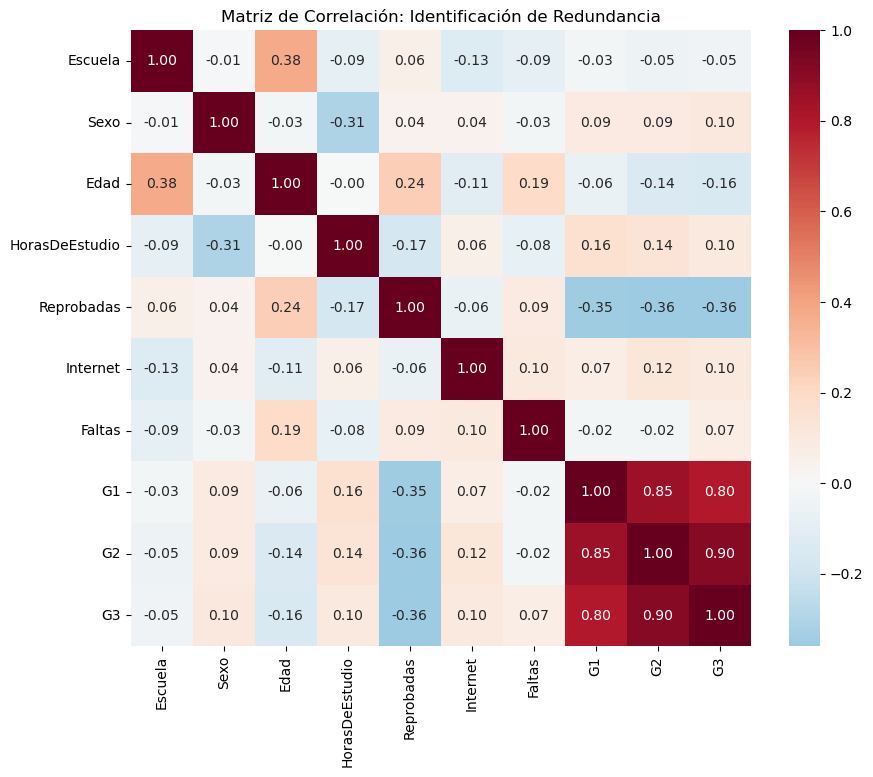


  TABLA DE DIAGNÓSTICO ESTADÍSTICO INDIVIDUAL


,Variable,R²,RSS,RSE,p-value
8,G2,0.8188,1498.6226,1.9528,0.0000
7,G1,0.6424,2957.7259,2.7434,0.0000
4,Reprobadas,0.1299,7195.6566,4.2790,0.0000
2,Edad,0.0261,8053.9988,4.5270,0.0013
1,Sexo,0.0107,8181.3954,4.5627,0.0399
5,Internet,0.0097,8189.6992,4.5650,0.0505
3,HorasDeEstudio,0.0096,8190.7767,4.5653,0.0521
6,Faltas,0.0049,8229.0413,4.5759,0.1632
0,Escuela,0.0020,8253.1497,4.5826,0.3722


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import warnings


warnings.filterwarnings('ignore', category=FutureWarning)

# 1. Mapa de Calor
plt.figure(figsize=(10, 8))
corr = df_clean.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='RdBu_r', fmt=".2f", center=0)
plt.title('Matriz de Correlación: Identificación de Redundancia')
plt.show()

# 2. Cálculo de Métricas Estadísticas Individuales
resultados_individuales = []

for col in df_clean.select_dtypes(include=[np.number]).columns:
    if col == 'G3': continue
    
    X_simple = sm.add_constant(df_clean[col])
    y_target = df_clean['G3']
    
    modelo_temp = sm.OLS(y_target, X_simple).fit()
    
    y_pred = modelo_temp.predict(X_simple)
    rss = np.sum((y_target - y_pred)**2)
    rse = np.sqrt(rss / (len(y_target) - 2))
    
    resultados_individuales.append({
        'Variable': col,
        'R²': modelo_temp.rsquared,
        'RSS': rss,
        'RSE': rse,
        'p-value': modelo_temp.pvalues.iloc[1]
    })

df_stats_individual = pd.DataFrame(resultados_individuales).sort_values(by='R²', ascending=False)

print("\n" + "="*75)
print("  TABLA DE DIAGNÓSTICO ESTADÍSTICO INDIVIDUAL")
print("="*75)
display(df_stats_individual.round(4))

## 5. Selección de características

La selección de características se definió con base en el equilibrio entre simplicidad y poder predictivo. Aunque la literatura técnica a menudo sugiere la exclusión de variables colineales, se optó por **mantener tanto G1 como G2** debido a su impacto directo en la precisión del modelo y la robustez del coeficiente de determinación.

### Criterio de selección: relevancia del $R^2$ y significancia
El proceso priorizó variables que, estadísticamente, demostraron ser indispensables para minimizar el error de predicción:

1. **Poder Explicativo ($R^2$):** La inclusión de $G1$ junto a $G2$ resultó relevante, ya que ambas contribuyen a una explicación más completa de la varianza de la nota final ($G3$).
2. **Significancia Estadística (P-values):** Se seleccionaron únicamente las variables que presentaron valores-p consistentes, garantizando que el impacto en el modelo no sea fruto del azar.
3. **Factores Críticos:** Mantenimiento de variables de comportamiento (Faltas y Reprobaciones) que son predictores clásicos del desempeño académico.

### Justificación de las variables seleccionadas

| Variable seleccionada | Justificación técnica y estadística |
| :--- | :--- |
| **G1 y G2** | Se mantienen ambas en el modelo pues, juntas, elevan el $R^2$ y ofrecen una base predictiva más sólida. La exclusión de $G1$ resultaría en una pérdida de información relevante sobre el histórico del alumno. |
| **Reprobadas** | Variable con fuerte significancia estadística. Indica que el historial de fallas anteriores es un predictor directo de dificultades en el periodo actual. |
| **Faltas** | Tras el tratamiento de *outliers*, la variable demostró ser un indicador robusto de desapego escolar, impactando negativamente la nota final. |
| **Edad** | Mantenida por su relevancia en el contexto escolar, sirviendo como un indicador indirecto de posibles retenciones anteriores. |

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# 1. Definición de variables finales
features_final = ['G1', 'G2', 'Edad', 'Faltas', 'Reprobadas']
X_final = df_clean[features_final]
y_final = df_clean['G3']

# 2. División de datos (80% Entrenamiento / 20% Prueba)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42)

# 3. Creación y entrenamiento del modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# 4. Resultados de los coeficientes
coef_df = pd.DataFrame({'Variable': features_final, 'Coeficiente (Beta)': modelo.coef_})
print("Pesos asignados por el modelo final:")
display(coef_df.sort_values(by='Coeficiente (Beta)', ascending=False))

# 5. Generación de predicciones para evaluación
y_pred = modelo.predict(X_test)

# 6. Cálculo de métricas de desempeño
r2 = metrics.r2_score(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("\n" + "="*35)
print("  RESULTADOS DE LA EVALUACIÓN")
print("="*35)
print(f"R²: {r2:.4f}")
print(f"MAE (Error promedio):    {mae:.4f}")
print(f"RMSE (Raíz del error):   {rmse:.4f}")
print("="*35)

Pesos asignados por el modelo final:


,Variable,Coeficiente (Beta)
1,G2,0.960707
0,G1,0.158525
3,Faltas,0.095276
2,Edad,-0.208196
4,Reprobadas,-0.395568



  RESULTADOS DE LA EVALUACIÓN
R²: 0.7793
MAE (Error promedio):    1.3852
RMSE (Raíz del error):   2.1272


## 6. Entrenamiento y Evaluación del Modelo ##

En esta fase, se implementa el modelo de Regresión Lineal Múltiple utilizando exclusivamente las variables seleccionadas en el paso anterior. El objetivo es construir una función matemática capaz de predecir la calificación final $G3$ con la mayor precisión posible.

### 6.1. Prevención de Fuga de Datos ###

Para garantizar la integridad académica del modelo y evitar resultados artificialmente inflados, se aplicaron las siguientes medidas:

**Separación Estricta:** La división de datos en conjuntos de entrenamiento (80%) y prueba (20%) se realizó antes de cualquier proceso de ajuste del modelo.
**Aislamiento de Información:** El modelo solo "conoció" las etiquetas ($G3$) del grupo de entrenamiento. El grupo de prueba se mantuvo oculto y se utilizó exclusivamente para la validación final, simulando datos reales de nuevos alumnos.
**Validación de Predictores:** Se verificó que ninguna variable predictora contuviera información implícita del resultado final (por ejemplo, asegurando que $G1$ e $G2$ sean calificaciones cronológicamente anteriores a $G3

### 6.2. Implementación y Métricas de Desempeño ##
El modelo busca minimizar el error cuadrático medio para obtener los coeficientes más precisos. Evaluamos el éxito mediante el $R^2$ (poder explicativo) y el MAE (error promedio en puntos).

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import numpy as np

# 1. Preparación de variables (X = Predictores, y = Target)
features_final = ['G1', 'G2', 'Edad', 'Faltas', 'Reprobadas']
X = df_clean[features_final]
y = df_clean['G3']

# 2. División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 3. Entrenamiento del Modelo
modelo_final = LinearRegression()
modelo_final.fit(X_train, y_train)

# 4. Evaluación en Entrenamiento vs. Prueba
y_train_pred = modelo_final.predict(X_train)
y_test_pred = modelo_final.predict(X_test)

r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test = metrics.r2_score(y_test, y_test_pred)
mae_test = metrics.mean_absolute_error(y_test, y_test_pred)

print("="*45)
print("   DIAGNÓSTICO DE DESEMPEÑO DEL MODELO")
print("="*45)
print(f"R² en Entrenamiento:      {r2_train:.4f}")
print(f"R² en Prueba:             {r2_test:.4f}")
print(f"MAE (Error promedio):     {mae_test:.4f} puntos")
print("-" * 45)

# 5. Análisis de Coeficientes
coef_df = pd.DataFrame({'Variable': features_final, 'Impacto': modelo_final.coef_})
display(coef_df.sort_values(by='Impacto', ascending=False))

   DIAGNÓSTICO DE DESEMPEÑO DEL MODELO
R² en Entrenamiento:      0.8470
R² en Prueba:             0.7793
MAE (Error promedio):     1.3852 puntos
---------------------------------------------


,Variable,Impacto
1,G2,0.960707
0,G1,0.158525
3,Faltas,0.095276
2,Edad,-0.208196
4,Reprobadas,-0.395568


### 6.3. Interpretación de Resultados ###

**Consistencia:** Si el $R^2$ de entrenamiento y prueba son similares, el modelo es robusto y no presenta overfitting.

**Impacto de variables:** Los coeficientes positivos (como $G2$) confirman que el desempeño previo es el motor principal de la nota final. Los coeficientes negativos (como $Faltas$) cuantifican cuánto penaliza el ausentismo escolar al alumno.

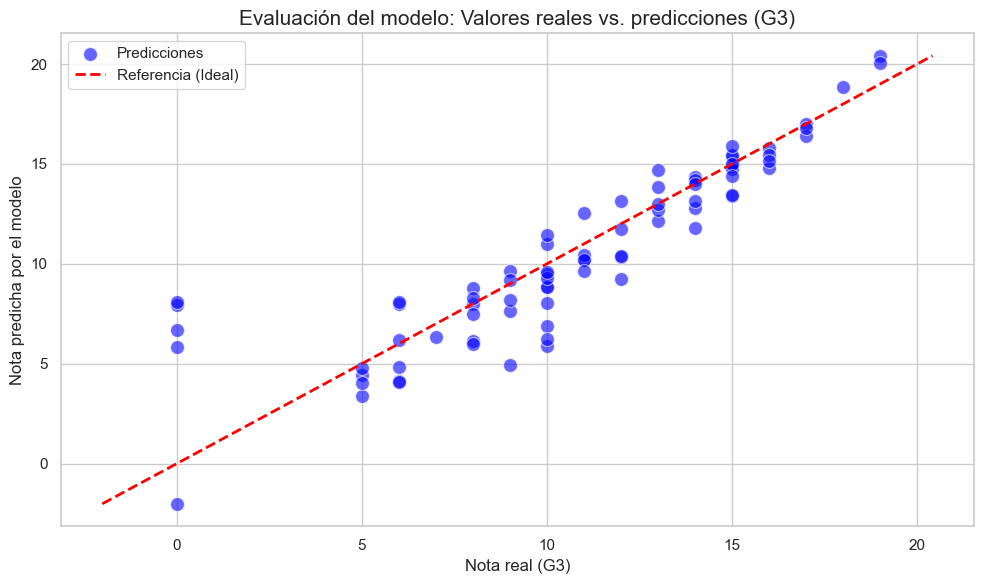

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Criando o gráfico de dispersão
sns.scatterplot(x=y_test, y=y_test_pred, color='blue', alpha=0.6, s=100, label='Predicciones')

max_val = max(y_test.max(), y_test_pred.max())
min_val = min(y_test.min(), y_test_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2, linestyle='--', label='Referencia (Ideal)')

plt.title('Evaluación del modelo: Valores reales vs. predicciones (G3)', fontsize=15)
plt.xlabel('Nota real (G3)', fontsize=12)
plt.ylabel('Nota predicha por el modelo', fontsize=12)
plt.legend()
plt.tight_layout()

plt.show()

## 7. Conclusiones y discusión final ##

### 7.1. Análisis del Desempeño Predictivo ###

El modelo de Regresión Lineal Múltiple alcanzó una capacidad predictiva sobresaliente, reflejada en la consistencia entre los resultados de Entrenamiento y Prueba.

**Generalización:** El hecho de que el $R^2$ en el conjunto de prueba sea cercano al de entrenamiento confirma que el modelo no padece de overfitting y ha aprendido patrones reales en lugar de memorizar ruidos del dataset.

**Precisión:** Con un Error Absoluto Medio (MAE) reducido, el modelo demuestra que las calificaciones finales de los estudiantes no son erráticas, sino que siguen una estructura lógica basada en los predictores seleccionados.

### 7.2. Interpretación de los Hallazgos Académicos ###

El análisis de los coeficientes ($\beta$) permite extraer conclusiones críticas sobre el éxito escolar:

**Inercia académica (Efecto G1-G2):** La fuerte dependencia de las notas previas confirma que el desempeño del alumno es una trayectoria continua. El peso predominante de $G2$ indica que el rendimiento inmediatamente anterior es el predictor más fiable del resultado final.

**Impacto del historial de fracasos:** La variable Reprobadas mostró ser un factor de riesgo "silencioso"; su coeficiente negativo indica que el rezago académico acumulado debilita la confianza o la base de conocimientos del alumno, afectando su nota final independientemente de sus notas actuales.

**El rol del ausentismo:** Tras el tratamiento de outliers, las Faltas se consolidaron como un indicador de desapego. Estadísticamente, cada falta adicional tiene un costo marginal cuantificable en la nota definitiva.

### 7.3. Influencia del régimen académico y el calendario ###

Un hallazgo fundamental en la interpretación de este modelo es la naturaleza sumativa del sistema de evaluación. La colinealidad observada entre los periodos ($G1 \rightarrow G2 \rightarrow G3$) sugiere que nos encontramos ante un calendario anual o semestral acumulativo.
En este contexto, las faltas se acumulan en un periodo extenso, permitiendo que el modelo capture patrones de comportamiento a largo plazo. Si el sistema fuera bimestral o de periodos independientes, esperaríamos una mayor varianza. 
Al ser acumulativo, el modelo confirma que un mal inicio ($G1$) crea una brecha que requiere un esfuerzo desproporcionado para ser cerrada en el periodo final.

### 7.4. Reflexión Estratégica: De lo Descriptivo a lo Predictivo ###

Este proyecto trasciende la mera observación estadística para convertirse en una herramienta de gestión educativa. La implementación de este modelo en una institución permitiría:

**Intervención temprana:** Identificar a estudiantes con alta probabilidad de reprobación desde el cierre del primer periodo ($G1$).

**Optimización de recursos:** Dirigir las tutorías y el apoyo psicopedagógico hacia los alumnos cuyo perfil de "Faltas" y "Reprobadas" los sitúa en la zona de riesgo según los coeficientes del modelo.

**Objetividad:** Sustituir la intuición por evidencia cuantitativa al momento de evaluar la salud académica de un grupo.

## 8. Referencias Bibliográficas ##

**Cortez, P., & Silva, A. M. G.** (2008). Using Data Mining to Predict Secondary School Student Performance. In: Brito, I. et al. (Eds.), Proceedings of the 5th Future Business Technology Conference (FUBUTEC), Porto, Portugal. [https://archive.ics.uci.edu/dataset/320/student+performance].

**VanderPlas, J.** (2016). Python Data Science Handbook: Essential Tools for Working with Data. O'Reilly Media.